**Index**:
- [Data loading](#Data-loading)
- [Individual models](#Individual-models)
    - [ANN](#ANN)
    - [ScikitLearn ANN](#ScikitLearn-ANN)
    - [Decision Tree](#Decision-Tree)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Support Vector Machine](#Support-Vector-Machine)
- [Base models results analysis](#Base-results-analysis) 
- [Ensemble models](#Ensemble-models)
- [Evaluation of the best ensemble](#Evaluation-of-the-best-ensemble)

# Fourth Approach: Dimensionality reduction using PCA and re-sampling with SMOTE

In this fouth approach, we will combine the approaches used in the second and third approach. We will preprocess the data by applying **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset, followed by **Synthetic Minority Over-sampling Technique (SMOTE)** to address class imbalance. First, we will load the data and apply PCA to all features to determine the optimal number of components, which will be selected based on the explained variance ratio. This allows us to retain as much of the data's variance as possible while reducing the dimensionality.

After the PCA transformation, we will apply SMOTE to generate synthetic samples for the minority class, balancing the dataset before training the models. This combination of dimensionality reduction and oversampling is aimed at improving model performance, particularly on imbalanced datasets.

To be able to compare the results with the rest of the approaches, we will use the same configuration of hyperparameters for the models:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [SMOTE Experiments](#SMOTE-experiments)
  - [SMOTE results and analysis](#SMOTE-results-and-analysis)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [ScikitLearn ANN](#ScikitLearn-ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
  - [Save the results](#save-the-results)
- [Ensemble models](#Ensemble-models)

## Data loading

In [1]:
using DataFrames
using CSV
using Serialization

In [ ]:
# Load custom functions from provided files
include("utils/preprocessing.jl")
include("utils/metrics.jl")
include("utils/training.jl")
include("utils/plotting.jl")

In [ ]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "datasets/dataset.csv"
data = CSV.read(dataset_path, DataFrame)
data[1:5, :]

5×35 DataFrame
 Row │ Marital status  Application mode  Application order  Course  Daytime/ev ⋯
     │ Int64           Int64             Int64              Int64   Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │              1                 8                  5       2             ⋯
   2 │              1                 6                  1      11
   3 │              1                 1                  5       5
   4 │              1                 8                  2      15
   5 │              2                12                  1       3             ⋯
                                                              31 columns omitted

In [ ]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [ ]:
inputs = Float32.(Matrix(inputs))

# Define the categories and their mapping
label_mapping = Dict("Dropout" => 0, "Graduate" => 1, "Enrolled" => 2)

# Encode the targets
targets_label_encoded = [label_mapping[label] for label in targets]

println("Encoded targets: ", targets_label_encoded[1:5])

# To decode later, create a reverse mapping
reverse_mapping = Dict(v => k for (k, v) in label_mapping)
decoded_targets = [reverse_mapping[code] for code in targets_label_encoded]

println("Decoded targets: ", decoded_targets[1:5])

Encoded targets: [0, 1, 0, 1, 1]
Decoded targets: ["Dropout", "Graduate", "Dropout", "Graduate", "Graduate"]


In [ ]:
# Split into training and testing sets
Random.seed!(42)
train_indices, test_indices = holdOut(inputs, targets, 0.15)
test_inputs = inputs[test_indices, :]
test_targets = targets[test_indices]
inputs = inputs[train_indices, :]
targets = targets[train_indices];

In [ ]:
function count_classes(targets::AbstractArray{<:Any,1})
    counts = Dict{Any, Int}()
    for target in targets
        counts[target] = get(counts, target, 0) + 1
    end
    return counts
end

# Ensure the frequency of each class is similar in the training and testing sets
count_train = count_classes(targets)
println("Training set distribution: ")
for (label, count) in count_train
    println("Label: ", label, ", Frequency ratio: ", count / length(targets))
end

count_test = count_classes(test_targets)
println("Testing set distribution: ")
for (label, count) in count_test
    println("Label: ", label, ", Frequency ratio: ", count / length(test_targets))
end

Training set distribution: 
Label: Enrolled, Frequency ratio: 0.17819148936170212
Label: Graduate, Frequency ratio: 0.5066489361702128
Label: Dropout, Frequency ratio: 0.3151595744680851
Testing set distribution: 
Label: Enrolled, Frequency ratio: 0.18674698795180722
Label: Graduate, Frequency ratio: 0.4578313253012048
Label: Dropout, Frequency ratio: 0.35542168674698793


In [ ]:
# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

## SMOTE Experiments

In this approach, it is necessary to conduct the SMOTE experiments again, mirroring the process used in approach 3. The key difference lies in the application of Principal Component Analysis (PCA) to the dataset prior to implementing SMOTE. This step is crucial because the previous experiments did not incorporate PCA, potentially leading to divergent results. By replicating the experiments with this added step, we can accurately assess the influence of PCA on the data before the application of SMOTE. This ensures a comprehensive evaluation of the combined effects of dimensionality reduction through PCA and synthetic sample generation via SMOTE on our dataset.

In [8]:
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50)
]
k = 5

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for (i, smote_percentage) in enumerate(smote_percentages)
      println("\nSmote percentages: ", smote_percentage)
      balanced_inputs, balanced_targets = smote(inputs, targets, smote_percentage, k)
      println("Number of instances: ", size(balanced_targets)[1])
      println("Elements of class Dropout: ", sum(balanced_targets .== "Dropout"))
      println("Elements of class Graduate: ", sum(balanced_targets .== "Graduate"))
      println("Elements of class Enrolled: ", sum(balanced_targets .== "Enrolled"))
    end
  end
end


Smote percentages: Dict("Enrolled" => 200)
Number of instances: 5218
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300)
Number of instances: 6012
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Dropout" => 200)
Number of instances: 6639
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300, "Dropout" => 200)
Number of instances: 7433
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Graduate" => 50)
Number of instances: 4113
Elements of class Dropout: 1421
Elements of class Graduate: 1104
Elements of class Enrolled: 1588


In [8]:
# Best configurations
topology = [32, 16]
topology_scikit_ann = [32]
max_depth = 5
n_neighbors = 11
kernel = "rbf"
C = 1

# ANN
hyperparameters_ann = Dict(
  "topology" => topology,
  "learningRate" => 0.01,
  "maxEpochs" => 100,
  "repetitionsTraining" => 10,
  "validationRatio" => 0.15,
  "maxEpochsVal" => 10,
  "minLoss" => 0.0001
)

# scikitANN
hyperparameters_scikit_ann = Dict(
  :hidden_layer_sizes => topology_scikit_ann,
  :learning_rate_init => 0.01,
  :max_iter => 100,
  :early_stopping => true,
  :tol => 0,
  :validation_fraction => 0.15,
  :n_iter_no_change => 10,
  :epsilon => 0.0001,
  :repetitionsTraining => 10
)

# DT
hyperparameters_dt = Dict(
  :max_depth => max_depth,
  :criterion => "gini",
  :min_samples_split => 2,
)

# SVM
hyperparameters_svm = Dict(
  :kernel => kernel,
  :C => C,
  :gamma => "auto",
  :probability => true,
)

# KNN
hyperparameters_knn = Dict(
  :n_neighbors => n_neighbors,
  :weights => "uniform",
  :metric => "euclidean",
)

# Define the hyperparameters for smote
k = 5
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String,Int}()
];

In [9]:
Random.seed!(42)

general_results_ann = []
class_results_ann = []
general_results_scikit_ann = []
class_results_scikit_ann = []
general_results_dt = []
class_results_dt = []
general_results_svm = []
class_results_svm = []
general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for smote_percentage in smote_percentages
      println("\nSmote percentage: ", smote_percentage)

      # ANN
      println("ANN")
      gr, cr = modelCrossValidation(
        :ANN,
        hyperparameters_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_ann, gr)
      push!(class_results_ann, cr)

      # Scikit ANN
      println("scikitANN")
      gr, cr = modelCrossValidation(
        :scikit_ANN,
        hyperparameters_scikit_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_scikit_ann, gr)
      push!(class_results_scikit_ann, cr)

      # DT
      println("DT")
      gr, cr = modelCrossValidation(
        :DT,
        hyperparameters_dt,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_dt, gr)
      push!(class_results_dt, cr)

      # SVM
      println("SVM")
      gr, cr = modelCrossValidation(
        :SVC,
        hyperparameters_svm,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_svm, gr)
      push!(class_results_svm, cr)

      # KNN
      println("KNN")
      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters_knn,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end


Smote percentage: Dict("Enrolled" => 200)
ANN


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(24 => 32, σ)
│   summary(x) = 24×3548 adjoint(::Matrix{Float64}) with eltype Float64
└ @ Flux /home/markel/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59


Mean accuracy: 0.51288 ± 0.02625
	Class 1: 0.45334 ± 0.04798
	Class 2: 0.46123 ± 0.0276
	Class 3: 0.76305 ± 0.05006
Mean precision: 0.23474 ± 0.03397
	Class 1: 0.24193 ± 0.06489
	Class 2: 0.2641 ± 0.03317
	Class 3: 0.14019 ± 0.11065
Mean recall: 0.33881 ± 0.03983
	Class 1: 0.4452 ± 0.08685
	Class 2: 0.35579 ± 0.10899
	Class 3: 0.1013 ± 0.08634
Mean f1_score: 0.22118 ± 0.0243
	Class 1: 0.25055 ± 0.04544
	Class 2: 0.26046 ± 0.07333
	Class 3: 0.0594 ± 0.03699
scikitANN
Mean accuracy: 0.82669 ± 0.00865
	Class 1: 0.83189 ± 0.01636
	Class 2: 0.8301 ± 0.0197
	Class 3: 0.81705 ± 0.00971
Mean precision: 0.70897 ± 0.02207
	Class 1: 0.75553 ± 0.03011
	Class 2: 0.72587 ± 0.04878
	Class 3: 0.5036 ± 0.0411
Mean recall: 0.73952 ± 0.01357
	Class 1: 0.84005 ± 0.07918
	Class 2: 0.76276 ± 0.09853
	Class 3: 0.28131 ± 0.06486
Mean f1_score: 0.71115 ± 0.01718
	Class 1: 0.7921 ± 0.04989
	Class 2: 0.73653 ± 0.07146
	Class 3: 0.34521 ± 0.04803
DT
Mean accuracy: 0.7743 ± 0.02742
	Class 1: 0.75545 ± 0.05874
	Cla

### SMOTE results and analysis

In [10]:
# Save the results
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "4_smote_results.jl"

parameters = Dict("Enrolled" => [200, 300, 200, 300, 200, 100], "Dropout" => [100, 100, 200, 200, 100, 100], "Graduate" => [100, 100, 100, 100, 50, 100])

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => parameters,
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => parameters,
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => parameters,
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => parameters,
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => parameters,
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [11]:
results_folder = "results/"
filename = results_folder * "4_smote_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end;

In [13]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach4/smote/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────────────────────────────┬──────────┬───────────┬──────────┬──────────┐
│                              Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────────────────────────────┼──────────┼───────────┼──────────┼──────────┤
│ Enrolled: 100, Graduate: 100, Dropout: 100 │ 0.797803 │  0.709361 │ 0.702825 │ 0.694731 │
│ Enrolled: 300, Graduate: 100, Dropout: 100 │ 0.782833 │  0.693434 │ 0.679096 │ 0.676134 │
│ Enrolled: 200, Graduate: 100, Dropout: 100 │ 0.791587 │  0.680377 │ 0.703955 │ 0.672764 │
│ Enrolled: 200, Graduate: 100, Dropout: 200 │ 0.769802 │  0.678528 │ 0.668927 │ 0.650682 │
│ Enrolled: 300, Graduate: 100, Dropout: 200 │ 0.769894 │  0.673491 │ 0.665537 │  0.64814 │
│  Enrolled: 200, Graduate: 50, Dropout: 100 │ 0.681453 │  0.611976 │ 0.528814 │ 0.538908 │
└────────────────────────────────────────────┴──────────┴───────────┴──────────┴──────────┘
Result

Based on the experimental results, here again, the optimal SMOTE configuration remains consistent: oversampling the minority class `Enrolled` by 300%, while maintaining the original proportions of the `Graduated` and `Dropout` classes. This consistency across different approaches provides additional validation for this specific sampling strategy.

## Individual models

### ANN

We are going to start with our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 5 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [8]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [ [64, 32], [16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 64]]

smote_percentage = Dict("Enrolled" => 300)

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [64, 32]


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(24 => 64, σ)
│   summary(x) = 24×4089 adjoint(::Matrix{Float64}) with eltype Float64
└ @ Flux /home/markel/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59


Mean accuracy: 0.47982 ± 0.01607
	Class 1: 0.42887 ± 0.0416
	Class 2: 0.45391 ± 0.02002
	Class 3: 0.64298 ± 0.07783
Mean precision: 0.14197 ± 0.01305
	Class 1: 0.18566 ± 0.03244
	Class 2: 0.11347 ± 0.03282
	Class 3: 0.14307 ± 0.01622
Mean recall: 0.26288 ± 0.02993
	Class 1: 0.45138 ± 0.08549
	Class 2: 0.11958 ± 0.08578
	Class 3: 0.32432 ± 0.11512
Mean f1_score: 0.15646 ± 0.025
	Class 1: 0.25357 ± 0.04865
	Class 2: 0.09377 ± 0.05291
	Class 3: 0.15708 ± 0.01812
Training ANN with topology: [16]
Mean accuracy: 0.62474 ± 0.15965
	Class 1: 0.62508 ± 0.18167
	Class 2: 0.59309 ± 0.18196
	Class 3: 0.7121 ± 0.07368
Mean precision: 0.42868 ± 0.222
	Class 1: 0.42294 ± 0.25372
	Class 2: 0.49795 ± 0.24668
	Class 3: 0.24627 ± 0.09799
Mean recall: 0.46514 ± 0.21263
	Class 1: 0.45999 ± 0.20878
	Class 2: 0.53805 ± 0.31049
	Class 3: 0.27173 ± 0.06576
Mean f1_score: 0.41526 ± 0.23912
	Class 1: 0.405 ± 0.25464
	Class 2: 0.48967 ± 0.29602
	Class 3: 0.22671 ± 0.07324
Training ANN with topology: [32]
Mean acc

### ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons

In [9]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.82777 ± 0.00987
	Class 1: 0.83456 ± 0.01318
	Class 2: 0.83195 ± 0.02173
	Class 3: 0.81339 ± 0.01233
Mean precision: 0.71755 ± 0.01794
	Class 1: 0.77728 ± 0.01203
	Class 2: 0.74182 ± 0.04103
	Class 3: 0.48617 ± 0.05491
Mean recall: 0.73995 ± 0.01472
	Class 1: 0.85383 ± 0.06644
	Class 2: 0.75204 ± 0.07896
	Class 3: 0.31919 ± 0.05729
Mean f1_score: 0.72173 ± 0.01507
	Class 1: 0.81201 ± 0.03159
	Class 2: 0.74341 ± 0.05653
	Class 3: 0.37971 ± 0.05035
Training ANN with topology: [32]
Mean accuracy: 0.82604 ± 0.00768
	Class 1: 0.83244 ± 0.01554
	Class 2: 0.82777 ± 0.01691
	Class 3: 0.81594 ± 0.00805
Mean precision: 0.71295 ± 0.01845
	Class 1: 0.77403 ± 0.00874
	Class 2: 0.73318 ± 0.03537
	Class 3: 0.48751 ± 0.0491
Mean recall: 0.73807 ± 0.01223
	Class 1: 0.85484 ± 0.06535
	Class 2: 0.76032 ± 0.0786
	Class 3: 0.29214 ± 0.06151
Mean f1_score: 0.71646 ± 0.01548
	Class 1: 0.81061 ± 0.02914
	Class 2: 0.74177 ± 0.05007
	Class 3: 0.35816 ± 0.06017
Tr

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [10]:
max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.7517 ± 0.01617
	Class 1: 0.72357 ± 0.04277
	Class 2: 0.78278 ± 0.03885
	Class 3: 0.78799 ± 0.0261
Mean precision: 0.62702 ± 0.01508
	Class 1: 0.66749 ± 0.03316
	Class 2: 0.732 ± 0.05336
	Class 3: 0.33511 ± 0.0616
Mean recall: 0.64717 ± 0.02218
	Class 1: 0.80864 ± 0.13684
	Class 2: 0.63461 ± 0.16354
	Class 3: 0.15619 ± 0.02805
Mean f1_score: 0.61797 ± 0.01959
	Class 1: 0.72479 ± 0.05528
	Class 2: 0.66666 ± 0.06408
	Class 3: 0.20837 ± 0.02073
Training DT model with max_depth: 5
Mean accuracy: 0.7713 ± 0.01522
	Class 1: 0.76176 ± 0.03934
	Class 2: 0.77285 ± 0.03674
	Class 3: 0.78549 ± 0.04121
Mean precision: 0.67073 ± 0.03039
	Class 1: 0.67171 ± 0.175
	Class 2: 0.64161 ± 0.19976
	Class 3: 0.51896 ± 0.26887
Mean recall: 0.66005 ± 0.02133
	Class 1: 0.66121 ± 0.17977
	Class 2: 0.65458 ± 0.20001
	Class 3: 0.45044 ± 0.16693
Mean f1_score: 0.6597 ± 0.02309
	Class 1: 0.65983 ± 0.15925
	Class 2: 0.64494 ± 0.19271
	Class 3: 0.47709 ± 0.20733
Tra

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [11]:
kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    applyPCA=true,
    pcaComponents=0.95,
    applySmote=true,
    smotePercentages=smote_percentage,
    smoteNeighbors=k,
    verbose=false
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.82406 ± 0.0069
	Class 1: 0.83476 ± 0.01414
	Class 2: 0.81467 ± 0.02195
	Class 3: 0.81623 ± 0.02129
Mean precision: 0.72168 ± 0.01054
	Class 1: 0.78057 ± 0.01706
	Class 2: 0.6365 ± 0.19143
	Class 3: 0.58736 ± 0.19664
Mean recall: 0.73283 ± 0.00997
	Class 1: 0.78727 ± 0.09262
	Class 2: 0.64578 ± 0.26407
	Class 3: 0.52042 ± 0.23849
Mean f1_score: 0.72458 ± 0.00951
	Class 1: 0.78163 ± 0.04568
	Class 2: 0.63863 ± 0.22658
	Class 3: 0.54963 ± 0.21928
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.82252 ± 0.00867
	Class 1: 0.83543 ± 0.015
	Class 2: 0.8124 ± 0.02216
	Class 3: 0.81374 ± 0.02162
Mean precision: 0.72192 ± 0.01187
	Class 1: 0.78188 ± 0.01878
	Class 2: 0.63905 ± 0.18941
	Class 3: 0.58396 ± 0.19779
Mean recall: 0.73079 ± 0.01256
	Class 1: 0.78822 ± 0.09109
	Class 2: 0.64161 ± 0.25035
	Class 3: 0.52773 ± 0.22534
Mean f1_score: 0.72409 ± 0.01166
	Class 1: 0.78274 ± 0.04442
	Class 2: 0.6382 ± 0.21804


### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [12]:
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applyPCA=true,
        pcaComponents=0.95,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77162 ± 0.01075
	Class 1: 0.78705 ± 0.03084
	Class 2: 0.76494 ± 0.02215
	Class 3: 0.77895 ± 0.03251
Mean precision: 0.6551 ± 0.01694
	Class 1: 0.72747 ± 0.0118
	Class 2: 0.55317 ± 0.22418
	Class 3: 0.51833 ± 0.17009
Mean recall: 0.66547 ± 0.01845
	Class 1: 0.71358 ± 0.07424
	Class 2: 0.57416 ± 0.27618
	Class 3: 0.47159 ± 0.22735
Mean f1_score: 0.65809 ± 0.01706
	Class 1: 0.71907 ± 0.04002
	Class 2: 0.56193 ± 0.24783
	Class 3: 0.49084 ± 0.19922
Training KNN model with n_neighbors: 3
Mean accuracy: 0.77513 ± 0.01131
	Class 1: 0.77871 ± 0.03019
	Class 2: 0.78618 ± 0.02588
	Class 3: 0.76561 ± 0.02317
Mean precision: 0.66468 ± 0.0165
	Class 1: 0.73952 ± 0.0059
	Class 2: 0.72552 ± 0.01501
	Class 3: 0.34804 ± 0.05633
Mean recall: 0.66525 ± 0.01982
	Class 1: 0.72855 ± 0.08809
	Class 2: 0.7081 ± 0.09112
	Class 3: 0.34385 ± 0.04301
Mean f1_score: 0.66343 ± 0.01783
	Class 1: 0.73192 ± 0.04699
	Class 2: 0.7149 ± 0.05191
	Class 3: 0.34576 ± 0.

### Save the results

In order to be able to compare the results of the models without running the training again, we will save the results in a dictionary. The dictionary will have the following structure:

```julia
{
    :model: {
        'num_trained_models': int,
        'parameters': Dict{String, Any},
        'general_results': [
            {
                'accuracy': AbstractVector{Float64},
                'precision': AbstractVector{Float64},
                'recall': AbstractVector{Float64},
                'f1_score': AbstractVector{Float64},
            },
            ... # One element for each trained model
        ],
        'class_results': [
            [
                {
                    'accuracy': AbstractVector{Float64},
                    'precision': AbstractVector{Float64},
                    'recall': AbstractVector{Float64},
                    'f1_score': AbstractVector{Float64},
                },
                ... # One element for each class
            ],
            ... # One element for each trained model
        ]
    }
}
```

The results of all approaches will be avaiable in the `results` dictionary. The filename with the results of individual models of this first approach will be `1_individual_results.jl`.


In [13]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "4_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

### Base models results analysis

In [7]:
results_folder = "results/"
filename = results_folder * "4_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end


model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)
plots_output_dir = "./plots/Approach4/"
tables_output_dir = "./tables/Approach4/"

"./tables/Approach4/"

In [15]:
# Plot metrics for each algorithm
plotMetricsAlgorithm(loaded_obj, output_dir=plots_output_dir)

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.


In [16]:
# Plot metrics for each class
plotMetricsAlgorithm(loaded_obj, 3, output_dir=plots_output_dir)

Saved plots for DT and accuracy on Class 1.
Saved plots for DT and precision on Class 1.
Saved plots for DT and recall on Class 1.
Saved plots for DT and f1_score on Class 1.
Saved plots for DT and accuracy on Class 2.
Saved plots for DT and precision on Class 2.
Saved plots for DT and recall on Class 2.
Saved plots for DT and f1_score on Class 2.
Saved plots for DT and accuracy on Class 3.
Saved plots for DT and precision on Class 3.
Saved plots for DT and recall on Class 3.
Saved plots for DT and f1_score on Class 3.
Saved plots for KNN and accuracy on Class 1.
Saved plots for KNN and precision on Class 1.
Saved plots for KNN and recall on Class 1.
Saved plots for KNN and f1_score on Class 1.
Saved plots for KNN and accuracy on Class 2.
Saved plots for KNN and precision on Class 2.
Saved plots for KNN and recall on Class 2.
Saved plots for KNN and f1_score on Class 2.
Saved plots for KNN and accuracy on Class 3.
Saved plots for KNN and precision on Class 3.
Saved plots for KNN and re

In [8]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, output_dir=tables_output_dir, rev=true)


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.771303 │   0.67073 │ 0.660052 │ 0.659705 │
│      max_depth: 10 │  0.77159 │  0.644583 │ 0.662533 │ 0.651766 │
│      max_depth: 20 │ 0.760188 │  0.628635 │ 0.646484 │ 0.635761 │
│      max_depth: 15 │ 0.757201 │  0.628918 │ 0.645131 │ 0.635133 │
│ max_depth: nothing │ 0.754736 │  0.622718 │ 0.639253 │ 0.629513 │
│       max_depth: 3 │ 0.751703 │  0.627024 │ 0.647171 │ 0.617973 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach4/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

In [9]:
generateAlgorithmTables(loaded_obj, 3, sort_by=:F1_Score, output_dir=tables_output_dir, rev=true)


Comparison of Hyperparameter Configurations for DT on Class 1 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 3 │ 0.723574 │  0.667486 │ 0.808642 │ 0.724791 │
│      max_depth: 20 │ 0.761297 │  0.694823 │ 0.753606 │  0.72294 │
│ max_depth: nothing │ 0.752261 │  0.687367 │ 0.731005 │ 0.708495 │
│       max_depth: 5 │ 0.761765 │  0.671714 │ 0.661215 │ 0.659826 │
│      max_depth: 10 │ 0.783667 │  0.643029 │ 0.657728 │ 0.648759 │
│      max_depth: 15 │  0.75949 │  0.604512 │  0.62513 │ 0.611645 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT on Class 1 saved to ./tables/Approach4/.

Comparison of Hyperparameter Configurations for DT on Class 2 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Acc

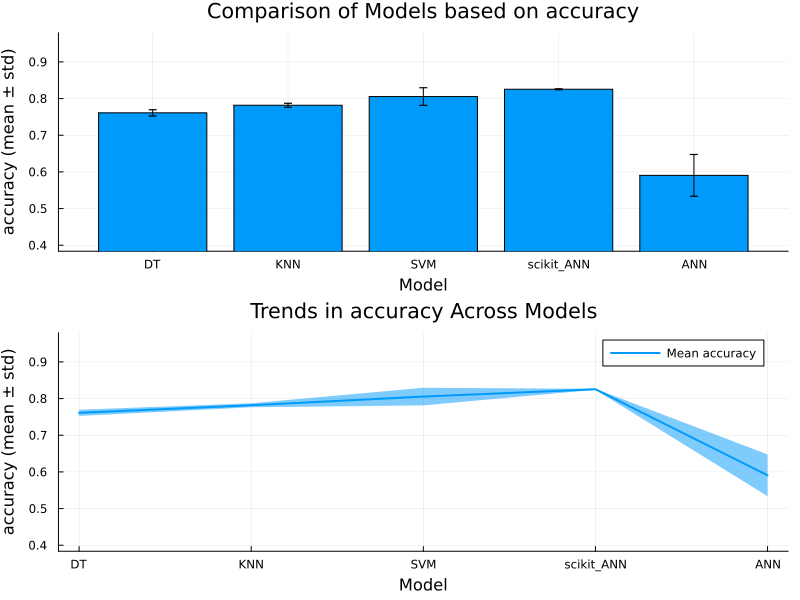

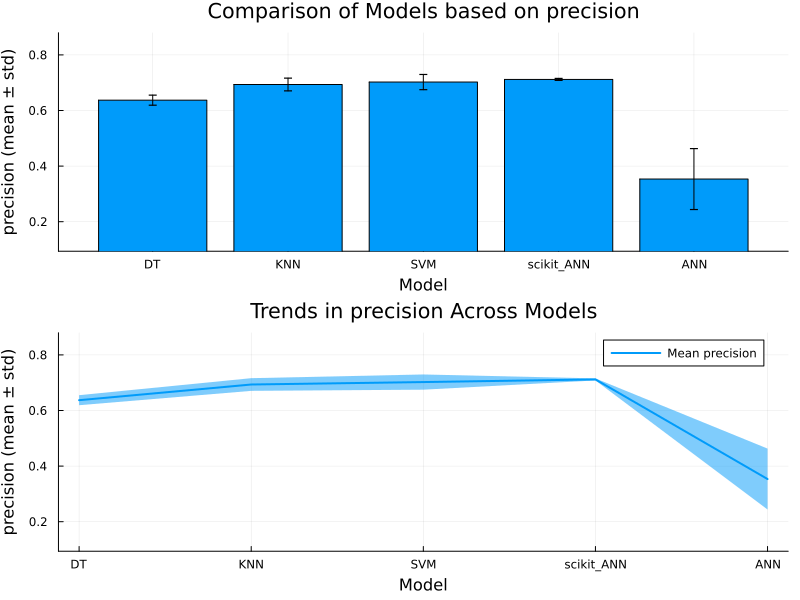

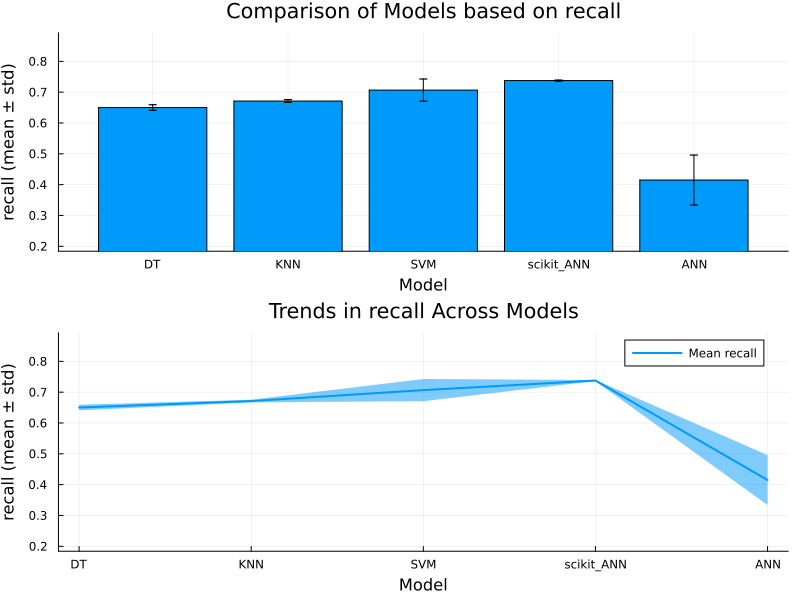

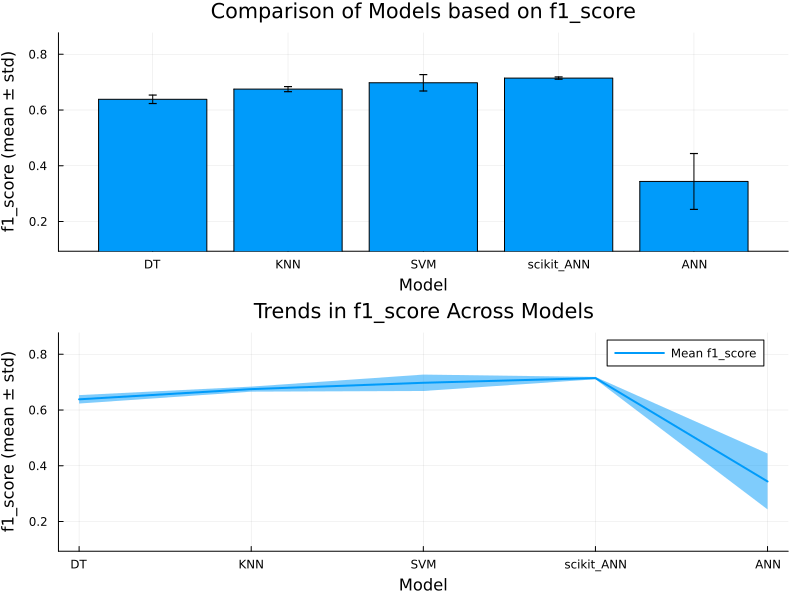

In [19]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir=plots_output_dir, show=true)

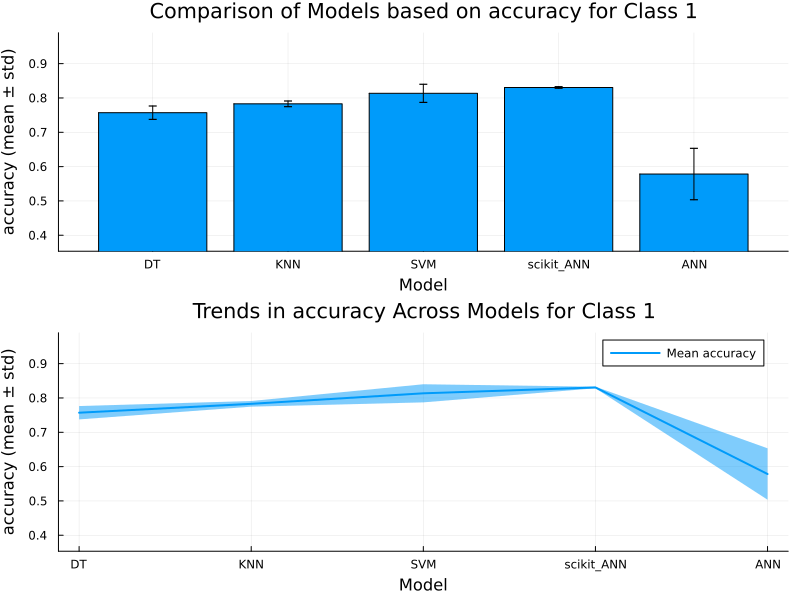

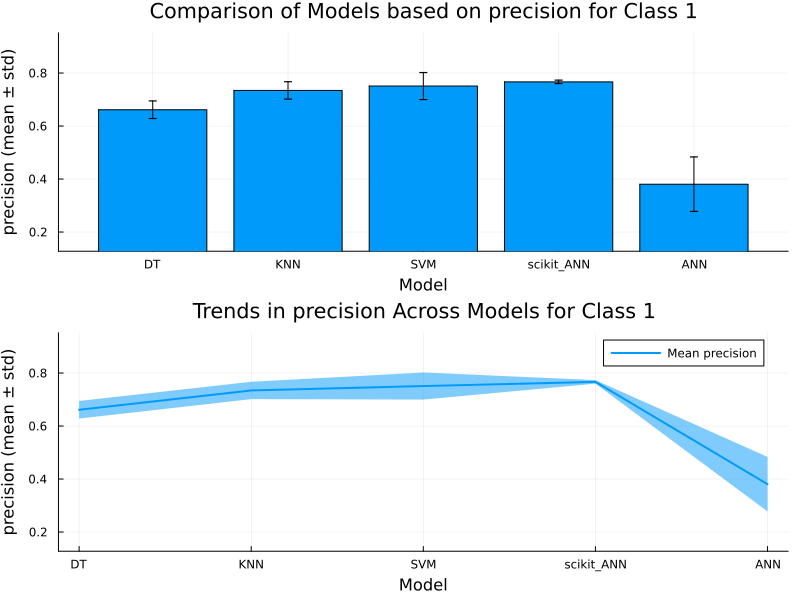

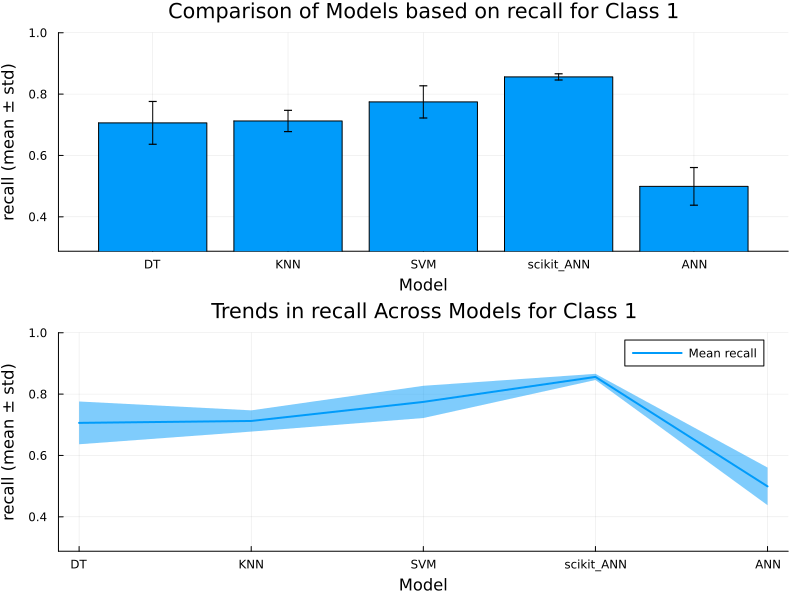

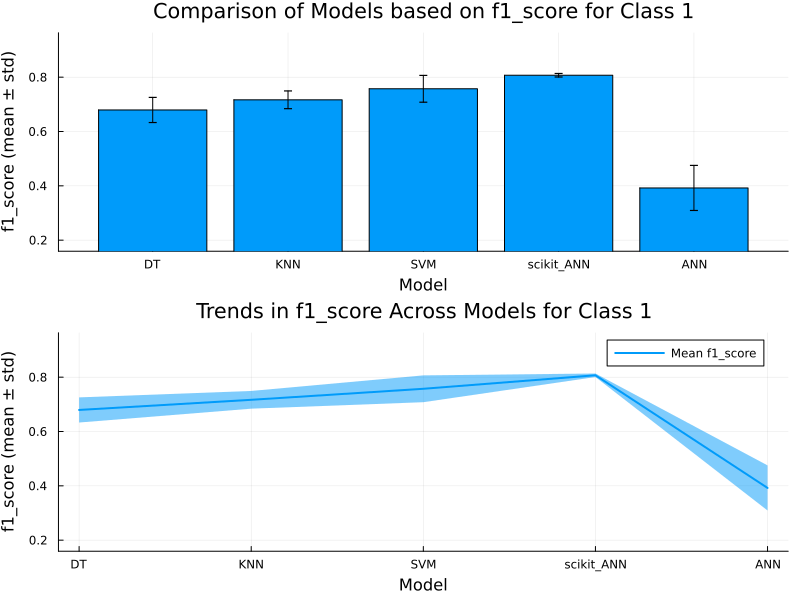

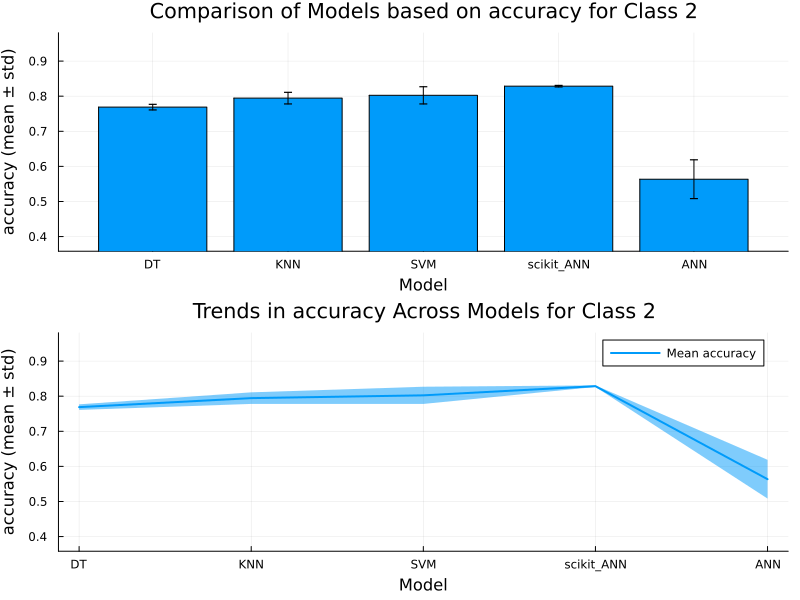

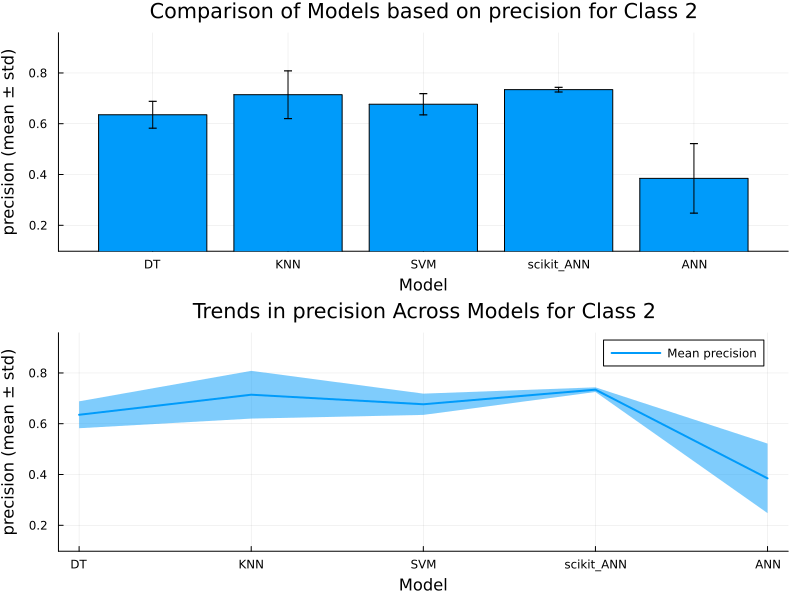

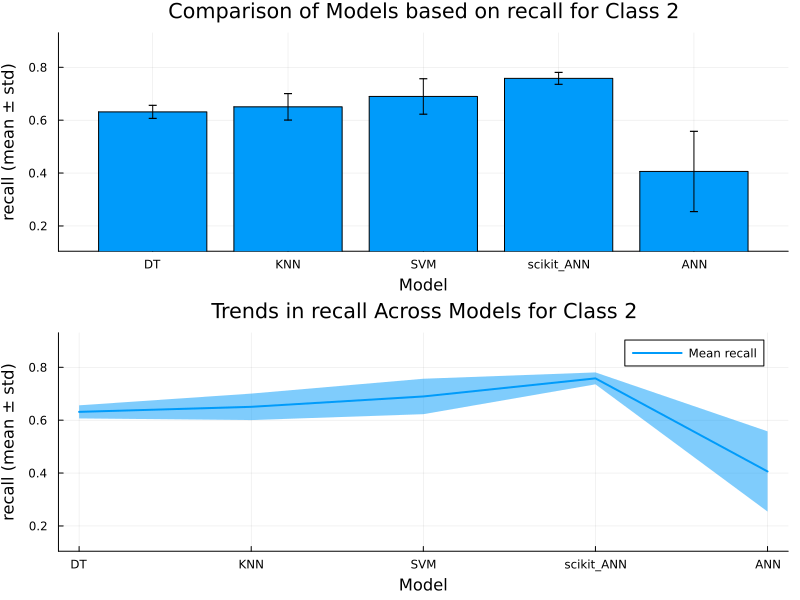

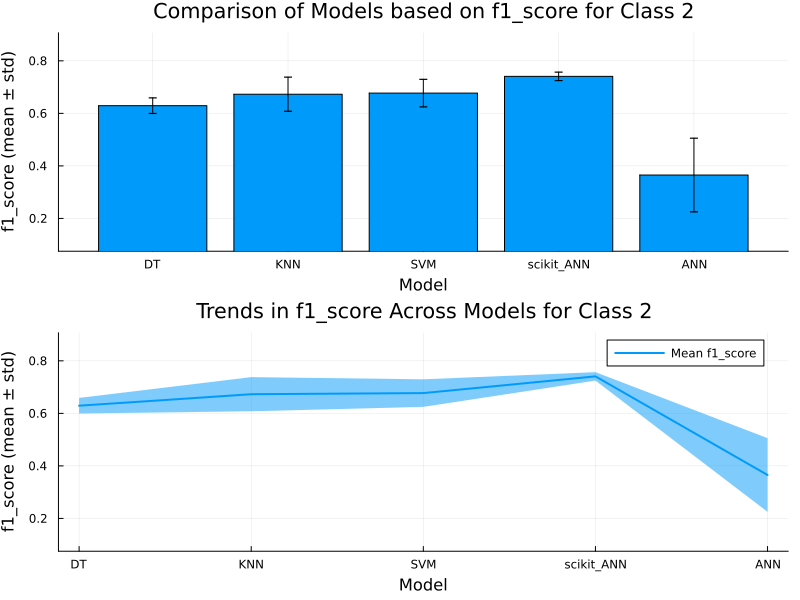

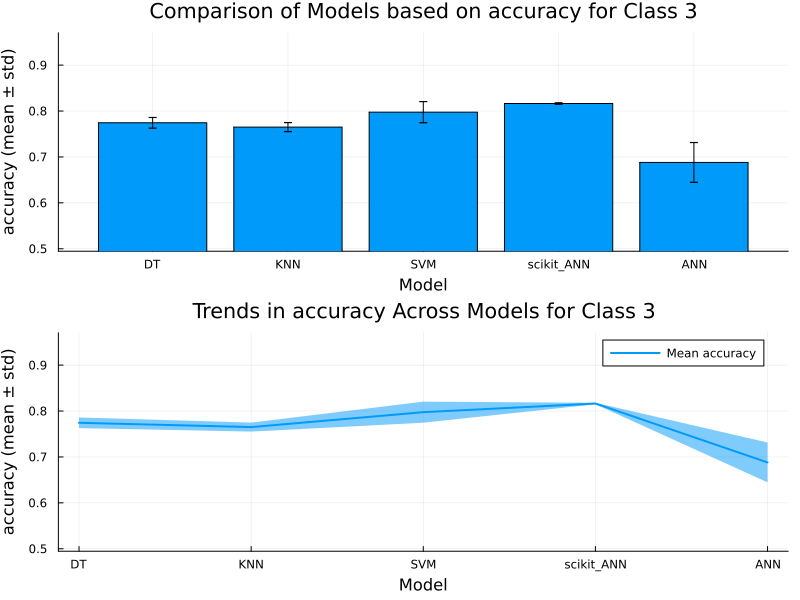

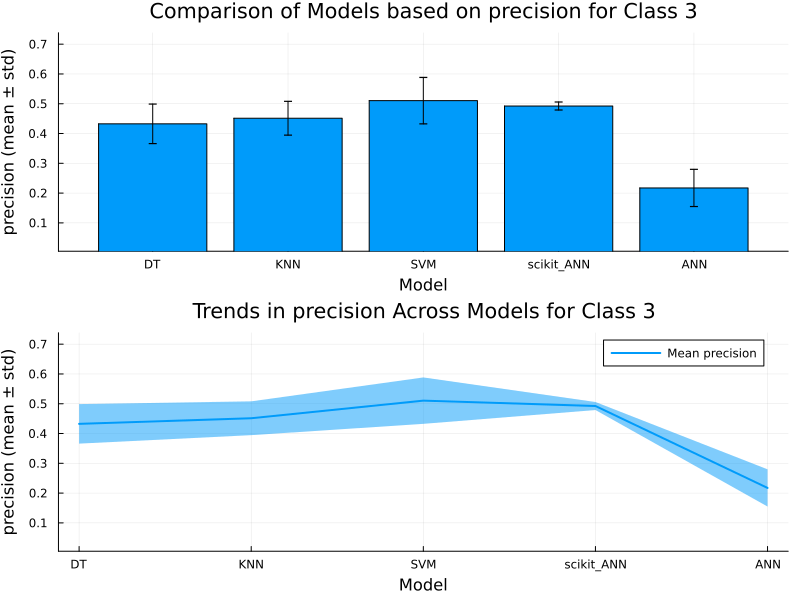

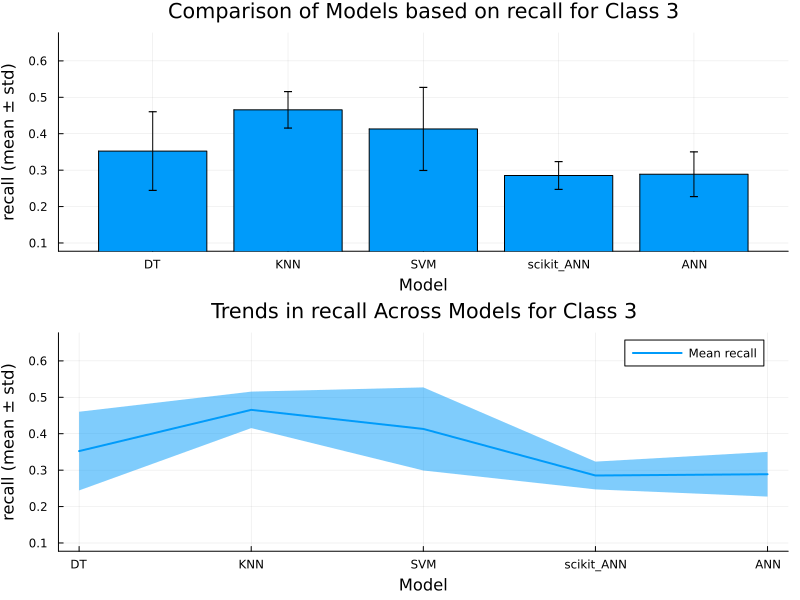

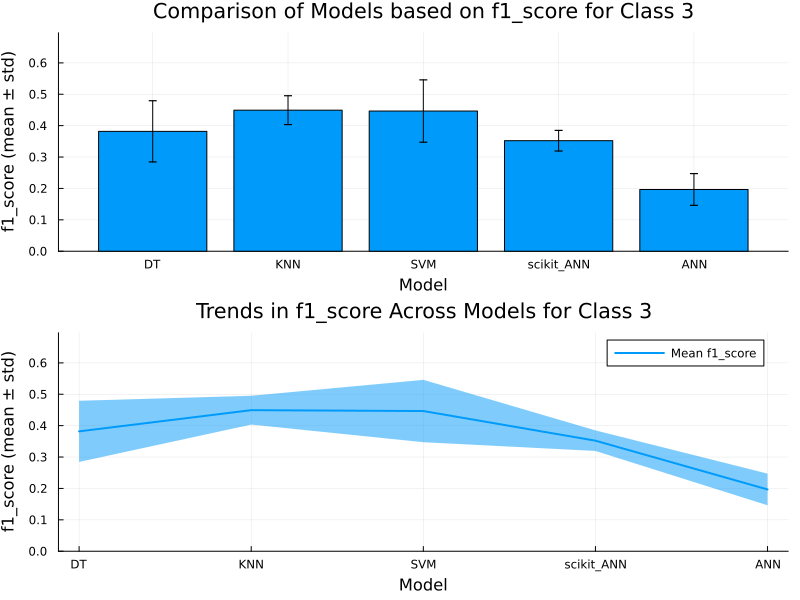

In [20]:
# Plot combined bar and line metrics per class
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir=plots_output_dir, show=true)

In [10]:
# Generate and print the overall comparison table
generateComparisonTable(model_names, metrics, metric_maxes; output_dir=tables_output_dir, sort_by=:accuracy, rev=true)


Comparison of Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.829 │     0.734 │  0.744 │    0.725 │
│ scikit_ANN │    0.828 │     0.718 │   0.74 │    0.722 │
│        KNN │    0.787 │     0.716 │  0.675 │    0.683 │
│         DT │    0.772 │     0.671 │  0.663 │     0.66 │
│        ANN │    0.662 │     0.476 │  0.518 │     0.48 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [11]:
# Generate and print the overall comparison table by class
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; output_dir=tables_output_dir, sort_by=:accuracy, rev=true)


Comparison of Metrics Across Models for Class 1 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.835 │       0.8 │  0.854 │    0.812 │
│ scikit_ANN │    0.835 │     0.777 │  0.868 │    0.812 │
│        KNN │      0.8 │     0.775 │  0.772 │    0.762 │
│         DT │    0.784 │     0.695 │  0.809 │    0.725 │
│        ANN │     0.66 │     0.525 │  0.602 │    0.539 │
└────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Models for Class 2 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│ scikit_ANN │    0.832 │     0.743 │   0.79 │    0.763 │
│        SVM │     0.83 │     0.744 │  0.836 │    0.782 │
│        KNN │    0.812 │     0.817 │  0.708 │

## Ensemble models

After training the individual models, we will train an ensemble model with the three best models (taking Scikit Learn ANN instead of ANN), taking each of the best configurations. This is:

- **Support Vector Machine**: `C: 0.1, kernel: linear`
- **K-Nearest Neighbors**: `n_neigbors: 13`
- **Decision Tree**: `max_depth: 5`


The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Stacking** (using a logistic regression as the meta-model)


### Training

In [20]:
# Select the best models
estimators = [:SVC, :KNN, :DT]
hyperparameters = Vector{Dict}([
  Dict(
  :kernel => "linear",
  :C => 0.1,
  :gamma => "auto",
  :probability => true,
  ),
  Dict(
    :n_neighbors => 13,
    :weights => "uniform",
    :metric => "euclidean",
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
  )])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.5, 0.3, 0.2]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:type => :Voting, :hyperparameters => Dict{Any, Any}())
 Dict(:type => :Voting, :hyperparameters => Dict{Symbol, Any}(:voting => "soft", :weights => [0.5, 0.3, 0.2]))
 Dict(:type => :Stacking, :hyperparameters => Dict{Symbol, PyCall.PyObject}(:final_estimator => PyObject LogisticRegression()))

In [21]:
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

for (index, ensemble) in enumerate(ensembles)
    println("Training ensemble ", ensemble[:type])
    metrics, class_results = trainClassEnsemble(
        estimators,
        hyperparameters,
        (inputs, targets),
        fold_indices;
        ensembleType = ensemble[:type],
        ensembleHyperParameters = ensemble[:hyperparameters],
        metricsToSave = metrics_to_save,
        repetitionsTraining = 5,
        applyPCA = true,
        pcaComponents = 0.95,
        applySmote=true,
        smotePercentages=smotePercentages,
        smoteNeighbors=smoteNeighbors,
        verbose=false
    )
    ensemble[:results] = metrics
    ensemble[:class_results] = class_results
    println("------------------------------------")
end

Training ensemble Voting
Mean accuracy: 0.81714 ± 0.00996
	Class 1: 0.83069 ± 0.01372
	Class 2: 0.80767 ± 0.03048
	Class 3: 0.80606 ± 0.02312
Mean precision: 0.71827 ± 0.01608
	Class 1: 0.79091 ± 0.02583
	Class 2: 0.62749 ± 0.21435
	Class 3: 0.57094 ± 0.20793
Mean recall: 0.72221 ± 0.01516
	Class 1: 0.75795 ± 0.11821
	Class 2: 0.64672 ± 0.25889
	Class 3: 0.52169 ± 0.22352
Mean f1_score: 0.71614 ± 0.01458
	Class 1: 0.76927 ± 0.05374
	Class 2: 0.63412 ± 0.23055
	Class 3: 0.54278 ± 0.21009
------------------------------------
Training ensemble Voting
Mean accuracy: 0.82658 ± 0.00732
	Class 1: 0.84271 ± 0.01983
	Class 2: 0.82611 ± 0.03095
	Class 3: 0.80488 ± 0.0085
Mean precision: 0.73272 ± 0.01158
	Class 1: 0.81031 ± 0.03599
	Class 2: 0.72096 ± 0.18164
	Class 3: 0.51353 ± 0.15114
Mean recall: 0.73685 ± 0.01096
	Class 1: 0.7778 ± 0.1196
	Class 2: 0.71446 ± 0.20833
	Class 3: 0.47514 ± 0.21532
Mean f1_score: 0.73001 ± 0.00963
	Class 1: 0.78776 ± 0.04502
	Class 2: 0.71331 ± 0.18177
	Class 3: 

In [22]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "4_ensemble_results.jl"

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :Voting_Hard => Dict(
    "general_results" => ensembles[1][:results],
    "class_results" => ensembles[1][:class_results]
  ),
  :Voting_Soft => Dict(
    "general_results" => ensembles[2][:results],
    "class_results" => ensembles[2][:class_results]
  ),
  :Stacking => Dict(
    "general_results" => ensembles[3][:results],
    "class_results" => ensembles[3][:class_results]
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

### Ensemble model plots

In [23]:
filename = results_folder * "4_ensemble_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3, ensemble=true)
plots_output_dir = "./plots/Approach4/ensembles"
tables_output_dir = "./tables/Approach4/ensembles"

"./tables/Approach4/ensembles"

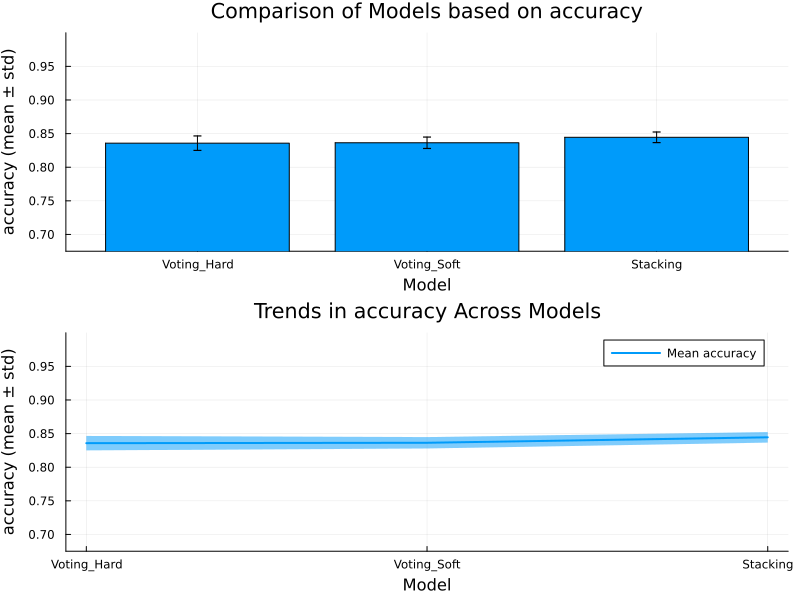

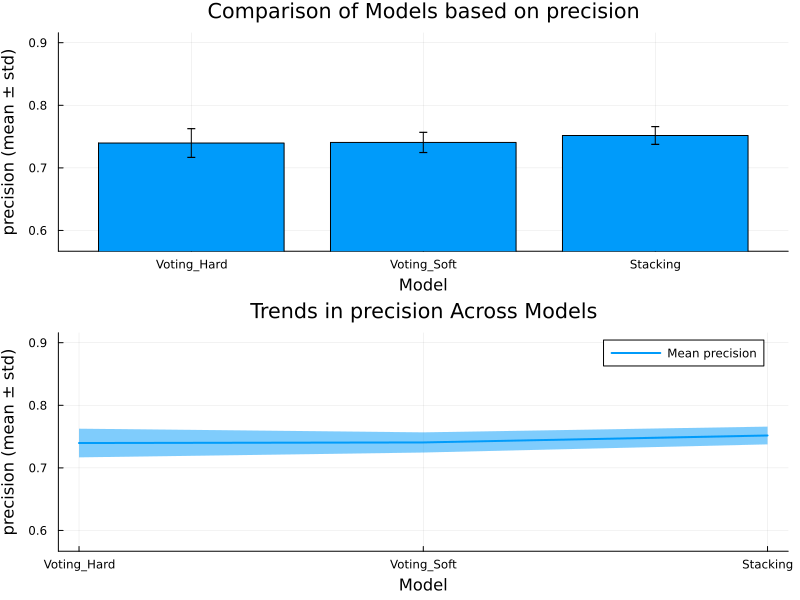

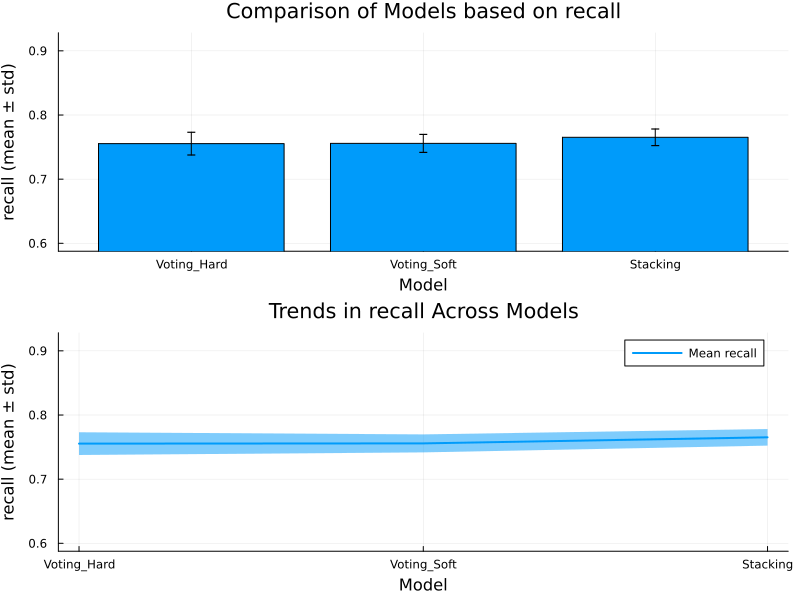

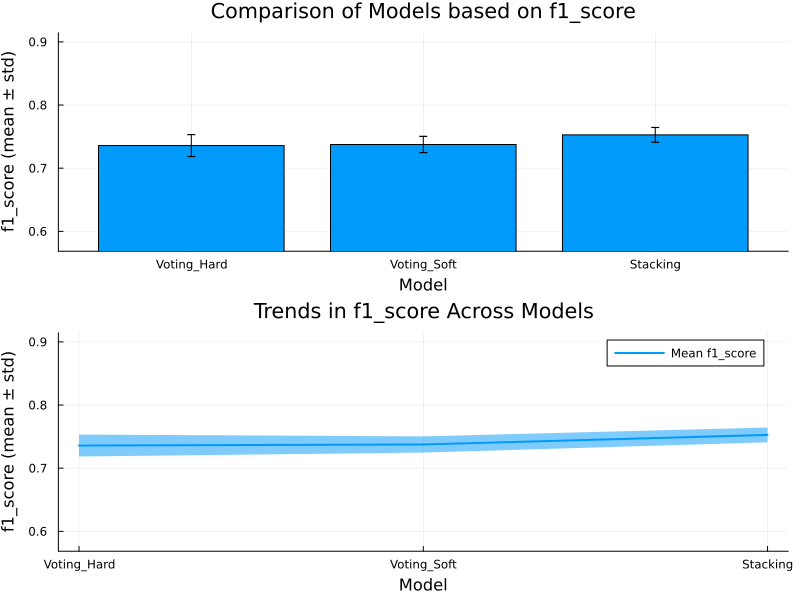

In [ ]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir=plots_output_dir, show=true)

In [ ]:
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir=plots_output_dir, show=true)

In [24]:
generateComparisonTable(model_names, metrics, metric_means; output_dir=tables_output_dir, sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│ Voting_Soft │    0.827 │     0.733 │  0.737 │     0.73 │
│    Stacking │    0.823 │     0.717 │  0.734 │    0.721 │
│ Voting_Hard │    0.817 │     0.718 │  0.722 │    0.716 │
└─────────────┴──────────┴───────────┴────────┴──────────┘


In [25]:
generateComparisonTable(model_names, 3, metrics, metric_means_class; output_dir=tables_output_dir, sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models for Class 1 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│ Voting_Soft │    0.843 │      0.81 │  0.778 │    0.788 │
│    Stacking │    0.836 │     0.776 │  0.802 │    0.787 │
│ Voting_Hard │    0.831 │     0.791 │  0.758 │    0.769 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Models for Class 2 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│ Voting_Soft │    0.826 │     0.721 │  0.714 │    0.713 │
│    Stacking │    0.823 │     0.698 │  0.709 │      0.7 │
│ Voting_Hard │    0.808 │     0.627 │  0.647 │    0.634 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Mo

# Evaluation of the best ensemble

The best result was obtained with the weighted voting method. So, we train it with the whole training dataset and evaluate it with the test set:

In [ ]:
Random.seed!(42)

smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

estimators = [:SVC, :KNN, :DT]
models_hyperparameters = Vector{Dict}([
  Dict(
  :kernel => "linear",
  :C => 0.1,
  :gamma => "auto",
  :probability => true,
  ),
  Dict(
    :n_neighbors => 13,
    :weights => "uniform",
    :metric => "euclidean",
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
  )])

type = :Voting
hyperparameters = Dict(
    :voting => "soft",
    :weights => [0.5, 0.3, 0.2]
  )

println("Training ensemble...")
metrics = trainEnsemble(
  estimators,
  models_hyperparameters,
  (inputs, targets),
  (test_inputs, test_targets);
  ensembleType=type,
  ensembleHyperParameters=hyperparameters,
  applyPCA=true,
  pcaComponents=0.95,
  applySmote=true,
  smotePercentages=smotePercentages,
  smoteNeighbors=smoteNeighbors
);

Training ensemble...


In [10]:
metrics_to_save = [:accuracy, :precision, :recall, :f1_score]
println("Metrics: ")
for metric in metrics_to_save
  println("\t", metric, ": ", round(metrics[metric], digits=5))
end

Metrics: 
	accuracy: 0.82262
	precision: 0.7263
	recall: 0.72892
	f1_score: 0.72518


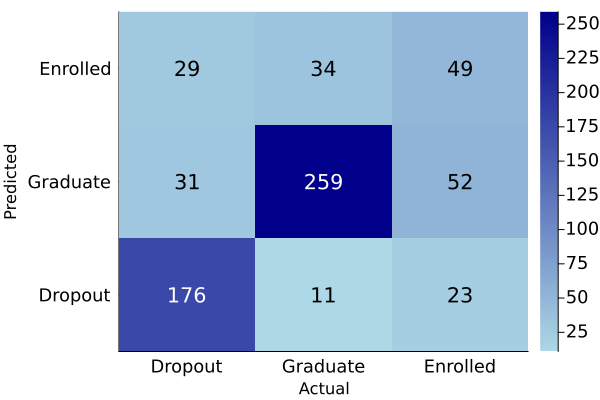

In [11]:
conf_matrix = metrics[:confusion_matrix]
showConfusionMatrix(conf_matrix; output_dir="./plots/Approach4/", filename="voting_soft_confusion_matrix.png");